# Flattened dT analysis
Full combinatorics

In [1]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") # suppress warnings

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# ML tools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Internal modules 
sys.path.extend(["../../src/core", "../../src/utils"])
from draw import Draw
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot() # just use this for styles

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Load data

In [73]:
!ls -ltrh ../../output/dt/

total 0
drwxr-sr-x  3 sgrant  staff    96B Dec  2 13:56 cosmic
drwxr-sr-x  3 sgrant  staff    96B Dec  2 14:00 test
drwxr-sr-x  3 sgrant  staff    96B Dec  2 14:10 a


In [74]:
!ls -ltrh ../../output/dt/a
!ls -ltrh ../../output/dt/a/data
# !ls -ltrh ../../output/dt/a/data/

total 0
drwxr-sr-x  6 sgrant  staff   192B Dec  2 15:37 data
total 0
drwxr-sr-x  6 sgrant  staff   192B Dec  2 14:14 CRY_onspill-LH_aw
drwxr-sr-x  6 sgrant  staff   192B Dec  2 14:18 CRY_mix2BB_onspill-LH_aw
drwxr-sr-x  6 sgrant  staff   192B Dec  2 15:37 CE_onspill-LH_aw
drwxr-sr-x  6 sgrant  staff   192B Dec  2 15:39 CE_mix_onspill-LH_aw
total 0
drwxr-sr-x  6 sgrant  staff   192B Dec  2 14:14 CRY_onspill-LH_aw
drwxr-sr-x  6 sgrant  staff   192B Dec  2 14:18 CRY_mix2BB_onspill-LH_aw
drwxr-sr-x  6 sgrant  staff   192B Dec  2 15:37 CE_onspill-LH_aw
drwxr-sr-x  6 sgrant  staff   192B Dec  2 15:39 CE_mix_onspill-LH_aw


In [128]:
run = "a"
base_in_path = Path(f"../../output/dt/{run}/data/")

# Load both test datasets
cry_path = base_in_path / "CRY_onspill-LH_aw/"
ce_mix2bb_path = base_in_path / "CE_mix2BB_onspill-LH_aw/"

print(f"Loading CRY data from: {cry_path}")
cry_data = Load(in_path=cry_path).load_pkl()["events"]

print(f"Loading CE Mix2BB data from: {ce_mix2bb_path}")
ce_mix_data = Load(in_path=ce_mix2bb_path).load_pkl()["events"]

print(f"CRY events: {len(cry_data)}")
print(f"CE mix2BB events: {len(ce_mix_data)}")

Loading CRY data from: ../../output/dt/a/data/CRY_onspill-LH_aw
[Load] ✅ Initialised with out_path=../../output/dt/a/data/CRY_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../output/dt/a/data/CRY_onspill-LH_aw/results.pkl
Loading CE Mix2BB data from: ../../output/dt/a/data/CE_mix2BB_onspill-LH_aw
[Load] ✅ Initialised with out_path=../../output/dt/a/data/CE_mix2BB_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../output/dt/a/data/CE_mix2BB_onspill-LH_aw/results.pkl
CRY events: 23727
CE mix2BB events: 2139827


In [78]:
## Add duration
cry_data["duration"] = cry_data["timeEnd"] - cry_data["timeStart"]
ce_mix_data["duration"] = ce_mix_data["timeEnd"] - ce_mix_data["timeStart"]

In [111]:
# Make a start/end time cut 
# 50 < startTime < 1550 ns and endTime < 1690 ns
cry_data = cry_data[(cry_data["timeStart"] > 50) & (cry_data["timeStart"] < 1550) & (cry_data["timeEnd"] < 1690)]
ce_mix_data = ce_mix_data[(ce_mix_data["timeStart"] > 50) & (ce_mix_data["timeStart"] < 1550) & (ce_mix_data["timeEnd"] < 1690)]

## Verify data

In [112]:
from pyutils.pyprint import Print
printer = Print()
printer.print_n_events(cry_data, n_events=2)
printer.print_n_events(ce_mix_data, n_events=2)

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 2 event(s)...

-------------------------------------------------------------------------------------
event: 430241.0
subrun: 95.0
run: 1202.0
dT: 95.65186950012503
crv_x: 563.35693359375
crv_y: 2706.025390625
crv_z: 3240.578857421875
PEs: 807.2415161132812
nHits: 16.0
nLayers: 4.0
angle: 0.3260249197483063
timeStart: 1139.365234375
timeEnd: 1214.365234375
crv_time: 1112.3841552734375
PEs_per_hit: 50.45259475708008
t0: 1208.0360247735625
d0: 96.78047180175781
tanDip: 0.5298436284065247
maxr: 589.1268920898438
mom_mag: 86.7626724243164
duration: 75.0
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
event: 242861.0
subrun: 303.0
run: 1202.0
dT: 45.39353268890068
crv_x: 625.6521606445312
crv_y: 2710.683837890625
crv_z: -6735.23828125
PEs: 742.8091430664062
nHits: 16.0
nLayers: 

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../../output/images/dt/veto/a/features/h1o_2x3_features.png
	Wrote ../../../output/images/dt/veto/a/features/h1o_2x3_features.png


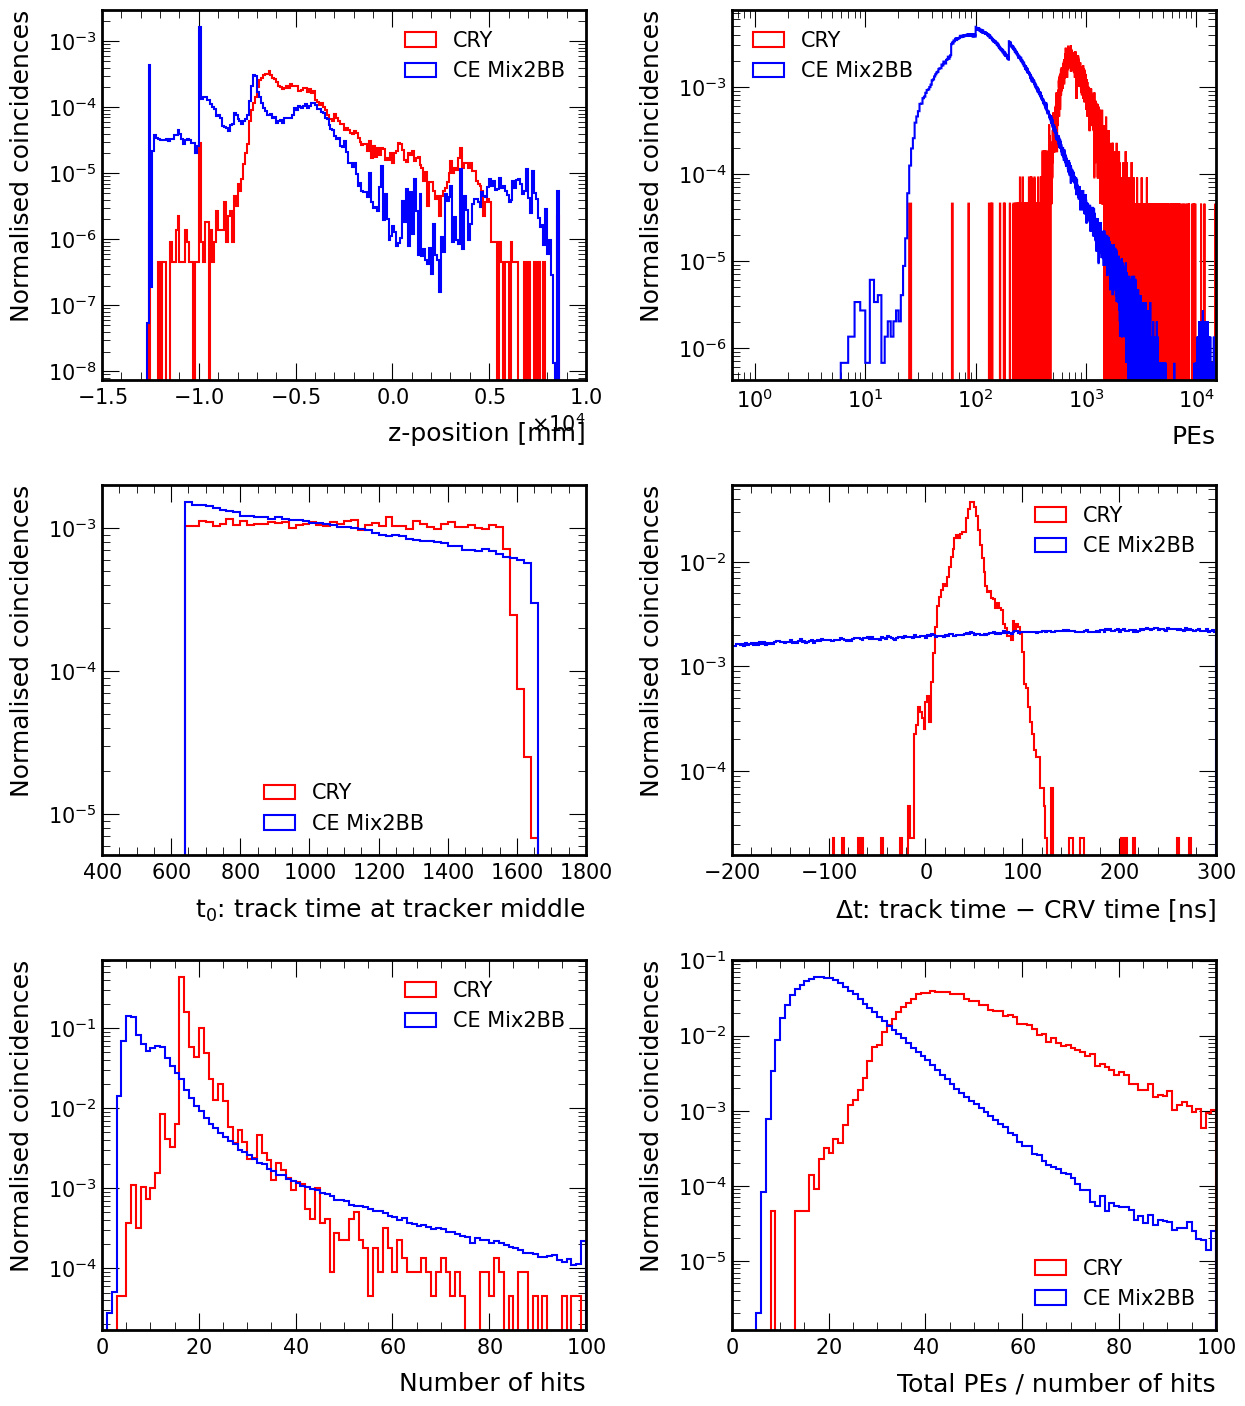

In [113]:
from pyutils.pyplot import Plot 
plotter = Plot()

fig, ax = plt.subplots(3, 2, figsize=(2*6.4, 3*4.8))

styles = {
    "CRY" : { 
        "color" : "red",# #0173B2"
        # "histtype" : "bar",
        # "alpha" : 0.4
    },
    "CE Mix2BB" : {
        "color" : "blue", # "#FF6600"
        # "histtype" : "bar",
        # "alpha" : 0.4
    }
}

# Plot 1: CRV z-position
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["crv_z"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["crv_z"], axis=-1),
    },
    nbins=250,
    xmin=-15000,
    xmax=10000,
    show=False,
    ax=ax[0,0],
    log_y=True,
    xlabel="z-position [mm]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 2: CRV PEs
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["PEs"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["PEs"], axis=-1),
    },
    nbins=int(1.5e4),
    xmin=0,
    xmax=1.5e4,
    show=False,
    ax=ax[0,1],
    log_y=True,
    log_x=True,
    xlabel="PEs", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 3: t0
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["t0"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["t0"], axis=-1),
    },
    nbins=70,
    xmin=400,
    xmax=1800,
    show=False,
    ax=ax[1,0],
    log_y=True,
    log_x=False,
    xlabel=r"$t_{0}$: track time at tracker middle", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 4: dT
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["dT"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["dT"], axis=-1),
    },
    nbins=int(250),
    xmin=-200,
    xmax=300,
    show=False,
    ax=ax[1,1],
    log_y=True,
    log_x=False,
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 5: PEs per hit (new feature)
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["PEs_per_hit"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["PEs_per_hit"], axis=-1),
    },
    nbins=int(100),
    xmin=0,
    xmax=100,
    show=False,
    ax=ax[2,1],
    log_y=True,
    log_x=False,
    xlabel=r"Total PEs / number of hits", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 6: Number of hits
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["nHits"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["nHits"], axis=-1),
    },
    nbins=int(100),
    xmin=0,
    xmax=100,
    show=False,
    ax=ax[2,0],
    log_y=True,
    log_x=False,
    xlabel=r"Number of hits", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

plt.tight_layout()

img_base_path = Path(f"../../../output/images/dt/veto/{run}/")
img_feature_out_path = img_base_path / "features"
img_feature_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h1o_2x3_features.png"

plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()

In [11]:
# !touch ../../../output/images/ml/veto/hello

	Wrote ../../../output/images/dt/veto/a/features/h2o_dT_vs_z.png


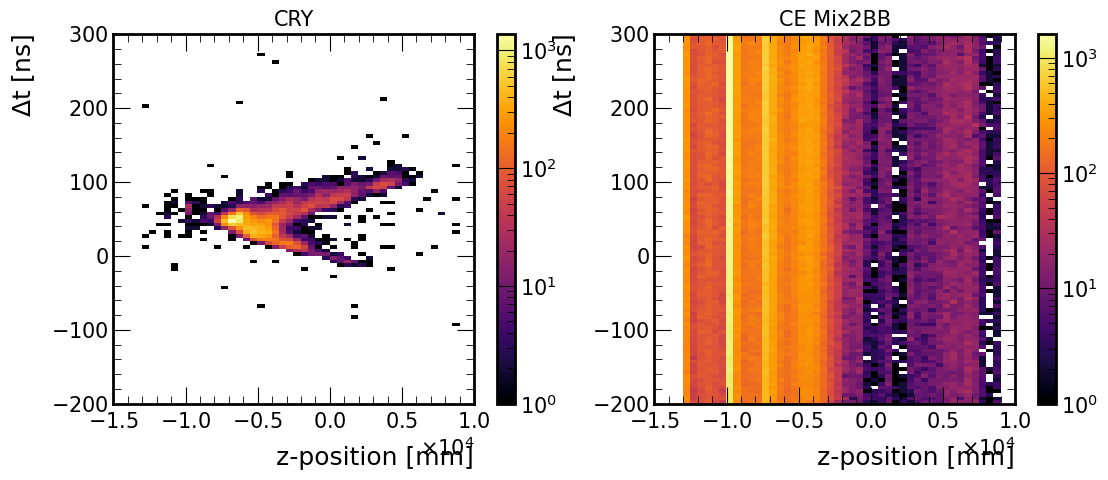

In [114]:
fig, ax = plt.subplots(1,2,figsize=(2*6.4, 4.8))
plotter.plot_2D(
    x = ak.flatten(cry_data["crv_z"], axis=-1),
    y = ak.flatten(cry_data["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CRY",
    ax=ax[0]
)
plotter.plot_2D(
    x = ak.flatten(ce_mix_data["crv_z"], axis=-1),
    y = ak.flatten(ce_mix_data["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CE Mix2BB",
    ax=ax[1]
)

# img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
# model_out_path = Path(f"../../../output/ml/veto/{run}/models/xgboost/features")
# img_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h2o_dT_vs_z.png"

plt.savefig(out_name)
print(f"\tWrote {out_name}")
# plt.show()



Convert to DataFrames and analyze the negative dT timing window.

In [115]:
# Convert awkward arrays to DataFrame
df_cry = ak.to_dataframe(cry_data)
df_mix = ak.to_dataframe(ce_mix_data)

print("CRY DataFrame:")
print(df_cry.head())
print(f"\nShape: {df_cry.shape}")
print("\nCE Mix2BB DataFrame:")
print(df_mix.head())
print(f"\nShape: {df_mix.shape}")

CRY DataFrame:
          event  subrun     run         dT        crv_x        crv_y  \
entry                                                                  
0      430241.0    95.0  1202.0  95.651870   563.356934  2706.025391   
1      242861.0   303.0  1202.0  45.393533   625.652161  2710.683838   
2      251404.0   335.0  1202.0  52.221441  -458.316559  2708.178223   
3      424207.0   397.0  1202.0  84.638133 -1663.167480  2714.258301   
4      172343.0   886.0  1202.0  78.270693 -1180.485352  2704.240234   

             crv_z          PEs  nHits  nLayers  ...    timeStart  \
entry                                            ...                
0      3240.578857   807.241516   16.0      4.0  ...  1139.365234   
1     -6735.238281   742.809143   16.0      4.0  ...   777.524658   
2     -4090.798340   566.269653   16.0      4.0  ...   928.575317   
3     -6369.890137   713.634033   16.0      4.0  ...   807.484375   
4       394.817749  1037.221191   17.0      4.0  ...   625.173096 

## Scan dT

In [116]:
# Use ALL coincidences (no selection)
print(f"Using all coincidences:")
print(f"CRY: {len(df_cry):,} coincidences")
print(f"Mix2BB: {len(df_mix):,} coincidences")
print(f"\nWill check if event is vetoed = has ANY coincidence in timing window")

Using all coincidences:
CRY: 21,963 coincidences
Mix2BB: 1,482,966 coincidences

Will check if event is vetoed = has ANY coincidence in timing window


In [117]:
def apply_dt_cut(df, dt_min, dt_max):
    """
    Apply dT timing window cut on event level.
    
    An event passes if ANY of its dT values fall within [dt_min, dt_max].
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with columns: event, subrun, dT (and other features)
    dt_min : float
        Lower bound of dT window (ns)
    dt_max : float
        Upper bound of dT window (ns)
    
    Returns:
    --------
    pass_events : set
        Set of (event, subrun) tuples that pass the cut
    efficiency : float
        Fraction of events that pass
    """
    # Find rows where dT is within the window
    in_window = (df['dT'] >= dt_min) & (df['dT'] <= dt_max)
    
    # Get unique (event, subrun) pairs that have at least one dT in window
    pass_events = set(zip(df.loc[in_window, 'event'], df.loc[in_window, 'subrun']))
    
    # Get total unique events
    total_events = set(zip(df['event'], df['subrun']))
    
    # Calculate efficiency
    efficiency = len(pass_events) / len(total_events) if len(total_events) > 0 else 0
    
    return pass_events, efficiency

# Test the function
dt_min, dt_max = -25, 150
pass_events_cry, eff_cry = apply_dt_cut(df_cry, dt_min, dt_max)
pass_events_mix, eff_mix = apply_dt_cut(df_mix, dt_min, dt_max)

print(f"dT window: [{dt_min}, {dt_max}] ns")
print(f"\nCRY:")
print(f"  Total events: {len(set(zip(df_cry['event'], df_cry['subrun']))):,}")
print(f"  Events passing: {len(pass_events_cry):,}")
print(f"  Efficiency: {eff_cry*100:.2f}%")

print(f"\nCE Mix2BB:")
print(f"  Total events: {len(set(zip(df_mix['event'], df_mix['subrun']))):,}")
print(f"  Events passing: {len(pass_events_mix):,}")
print(f"  Efficiency: {eff_mix*100:.2f}%")

dT window: [-25, 150] ns

CRY:
  Total events: 18,645
  Events passing: 18,640
  Efficiency: 99.97%

CE Mix2BB:
  Total events: 410,099
  Events passing: 150,781
  Efficiency: 36.77%
  Total events: 410,099
  Events passing: 150,781
  Efficiency: 36.77%


Scanning timing windows...
Scanned 273 window combinations

Minimum window at 99.9% CRY efficiency:
  dt_min=5 ns, dt_max=120 ns
  Width: 115 ns
  CRY efficiency: 99.92%
  CE Mix2BB deadtime: 26.69%
Scanned 273 window combinations

Minimum window at 99.9% CRY efficiency:
  dt_min=5 ns, dt_max=120 ns
  Width: 115 ns
  CRY efficiency: 99.92%
  CE Mix2BB deadtime: 26.69%
	Wrote ../../output/images/dt/a/h2_1x2_dt_eff_deadtime.png
	Wrote ../../output/images/dt/a/h2_1x2_dt_eff_deadtime.png


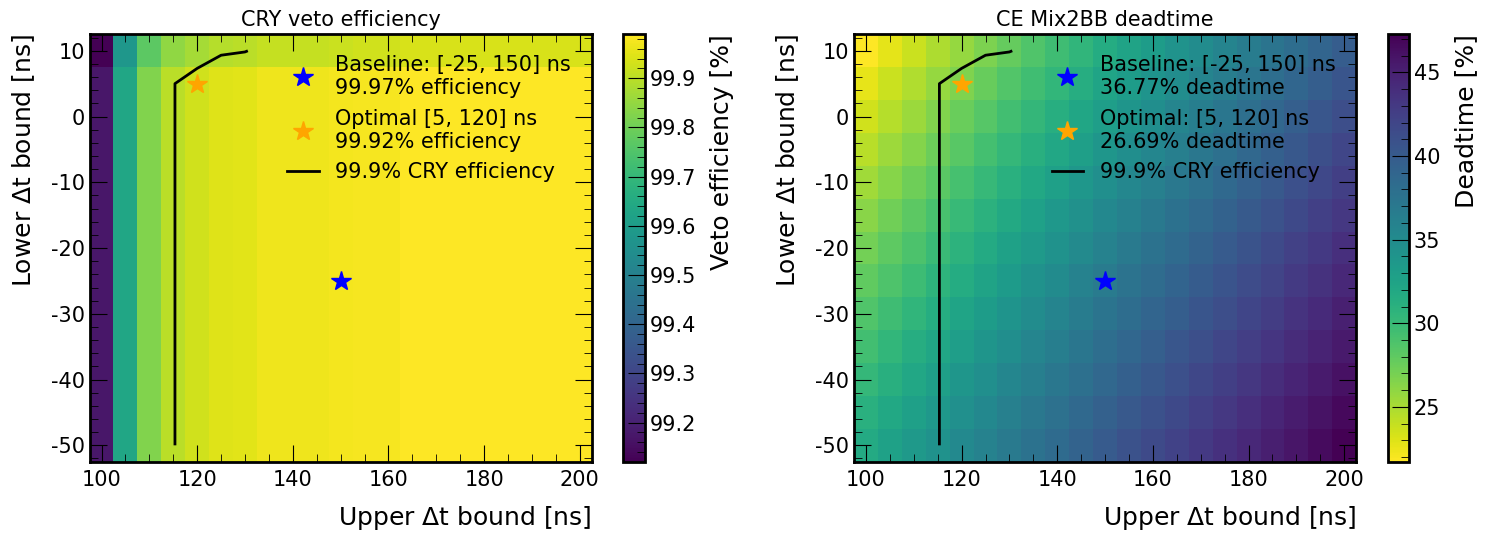

In [126]:
# Scan timing window ranges
print("Scanning timing windows...")

# Define ranges to scan
lower_bounds = np.arange(-50,15, 5) 
upper_bounds = np.arange(100, 205, 5) 

results = []
for dt_min in lower_bounds:
    for dt_max in upper_bounds:
        if dt_max <= dt_min:
            continue
        
        # Check if event is vetoed = has ANY coincidence in window
        # For CRY: want to veto (catch cosmics)
        cry_in_window = (df_cry['dT'] >= dt_min) & (df_cry['dT'] <= dt_max)
        cry_vetoed_events = df_cry[cry_in_window].groupby(['event', 'subrun']).size()
        cry_total_events = df_cry.groupby(['event', 'subrun']).size()
        eff_cry = len(cry_vetoed_events) / len(cry_total_events)
        
        # For CE Mix2BB: deadtime (fraction of events incorrectly vetoed)
        mix_in_window = (df_mix['dT'] >= dt_min) & (df_mix['dT'] <= dt_max)
        mix_vetoed_events = df_mix[mix_in_window].groupby(['event', 'subrun']).size()
        mix_total_events = df_mix.groupby(['event', 'subrun']).size()
        eff_mix = len(mix_vetoed_events) / len(mix_total_events)
        
        results.append({
            'dt_min': dt_min,
            'dt_max': dt_max,
            'width': dt_max - dt_min,
            'eff_cry': eff_cry * 100,
            'eff_mix': eff_mix * 100,
        })

df_scan = pd.DataFrame(results)
print(f"Scanned {len(df_scan)} window combinations")

# Find the minimum window width at 99.9% efficiency
df_99p9 = df_scan[df_scan['eff_cry'] >= 99.9].copy()
df_99p9['width'] = df_99p9['dt_max'] - df_99p9['dt_min']
min_width_idx = df_99p9['width'].idxmin()
optimal = df_99p9.loc[min_width_idx]
print(f"\nMinimum window at 99.9% CRY efficiency:")
print(f"  dt_min={optimal['dt_min']:.0f} ns, dt_max={optimal['dt_max']:.0f} ns")
print(f"  Width: {optimal['width']:.0f} ns")
print(f"  CRY efficiency: {optimal['eff_cry']:.2f}%")
print(f"  CE Mix2BB deadtime: {optimal['eff_mix']:.2f}%")

# Get baseline values
baseline = df_scan[(df_scan['dt_min'] == -25) & (df_scan['dt_max'] == 150)].iloc[0]

fig, axes = plt.subplots(1, 2, figsize=(1.2*6.4*2, 1.2*4.8))

# CRY veto efficiency
pivot_cry = df_scan.pivot(index='dt_min', columns='dt_max', values='eff_cry')
im1 = axes[0].pcolormesh(pivot_cry.columns, pivot_cry.index, pivot_cry.values, cmap='viridis')
contour_cry = axes[0].contour(pivot_cry.columns, pivot_cry.index, pivot_cry.values, levels=[99.9], colors='black', linewidths=2)
axes[0].set_xlabel(r'Upper $\Delta t$ bound [ns]')
axes[0].set_ylabel(r'Lower $\Delta t$ bound [ns]')
axes[0].set_title('CRY veto efficiency')
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Veto efficiency [%]')
axes[0].plot(150, -25, 'b*', markersize=15, linestyle='none', label=f'Baseline: [-25, 150] ns\n{baseline["eff_cry"]:.2f}% efficiency')
axes[0].plot(optimal['dt_max'], optimal['dt_min'], marker='*', color='orange', markersize=15, linestyle='none', label=f'Optimal [{optimal["dt_min"]:.0f}, {optimal["dt_max"]:.0f}] ns\n{optimal["eff_cry"]:.2f}% efficiency')
axes[0].plot([], [], 'k-', linewidth=2, label='99.9% CRY efficiency')
axes[0].legend(loc="best")


# CE Mix2BB deadtime
pivot_mix = df_scan.pivot(index='dt_min', columns='dt_max', values='eff_mix')
im2 = axes[1].pcolormesh(pivot_mix.columns, pivot_mix.index, pivot_mix.values, cmap='viridis_r')
contour_mix = axes[1].contour(pivot_cry.columns, pivot_cry.index, pivot_cry.values, levels=[99.9], colors='black', linewidths=2)
axes[1].set_xlabel(r'Upper $\Delta t$ bound [ns]')
axes[1].set_ylabel(r'Lower $\Delta t$ bound [ns]')
axes[1].set_title('CE Mix2BB deadtime')
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Deadtime [%]')
axes[1].plot(150, -25, 'b*', markersize=15, linestyle='none', label=f'Baseline: [-25, 150] ns\n{baseline["eff_mix"]:.2f}% deadtime')
axes[1].plot(optimal['dt_max'], optimal['dt_min'], marker='*', color='orange', markersize=15, linestyle='none', label=f'Optimal: [{optimal["dt_min"]:.0f}, {optimal["dt_max"]:.0f}] ns\n{optimal["eff_mix"]:.2f}% deadtime')
axes[1].plot([], [], 'k-', linewidth=2, label='99.9% CRY efficiency')
axes[1].legend(loc="best")

plt.tight_layout()

img_base_path = Path(f"../../output/images/dt/{run}")
img_base_path.mkdir(exist_ok=True, parents=True)
out_name = img_base_path / "h2_1x2_dt_eff_deadtime.png" # _bar_feature_importance.png"
plt.savefig(out_name, dpi=300)
print(f"\tWrote {out_name}")
plt.show()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../output/images/dt/a/h1_1x2_dT.png
	Wrote ../../output/images/dt/a/h1_1x2_dT.png


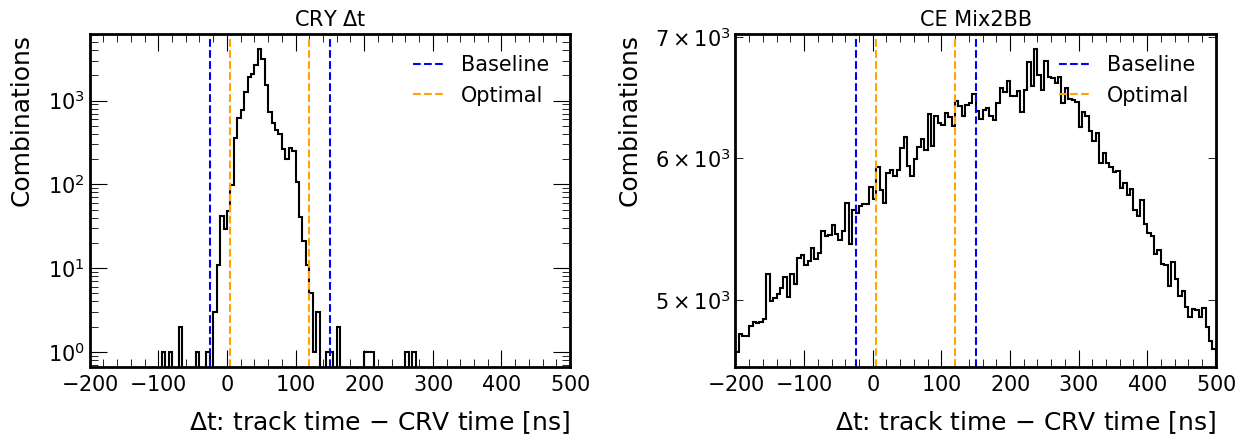

In [131]:
plotter = Plot()

fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 1*4.8))

# CRY distribution
plotter.plot_1D( 
    df_cry['dT'].values,
    nbins=140,
    xmin=-200, 
    xmax=500,
    title=r"CRY $\Delta t$",
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    ylabel=r"Combinations",
    show=False,
    col="black",
    ax=ax[0],
    log_y=True
)

# CE Mix2BB distribution
plotter.plot_1D( 
    df_mix['dT'].values,
    nbins=140,
    xmin=-200, 
    xmax=500,
    title=r"CE Mix2BB",
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    ylabel=r"Combinations",
    show=False,
    col="black",
    ax=ax[1],
    log_y=True
)

for i_ax, subplot in enumerate(ax):
    # Baseline
    subplot.axvline(-25, linestyle="--", color="blue", label="Baseline")
    subplot.axvline(150, linestyle="--", color="blue")
    # Optimal
    subplot.axvline(optimal['dt_min'], linestyle="--", color="orange", label="Optimal")
    subplot.axvline(optimal['dt_max'], linestyle="--", color="orange")
    subplot.legend()

plt.tight_layout()
out_name = img_base_path / "h1_1x2_dT.png"
plt.savefig(out_name, dpi=300)
print(f"\tWrote {out_name}")
plt.show()


[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../output/images/dt/a/h1_dT_centdT_overlay.png
	Wrote ../../output/images/dt/a/h1_dT_centdT_overlay.png


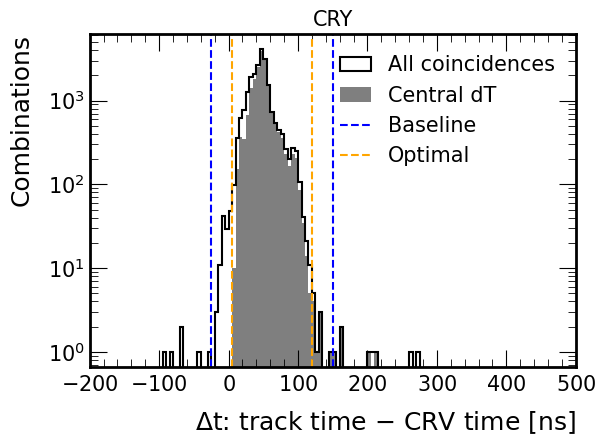

In [141]:
plotter = Plot()

# Get central dT for CRY (one per event - closest to window center)
window_center = (optimal['dt_min'] + optimal['dt_max']) / 2
df_cry['dist_to_center'] = np.abs(df_cry['dT'] - window_center)
central_dt_cry = df_cry.loc[df_cry.groupby(['event', 'subrun'])['dist_to_center'].idxmin()]['dT'].values

fig, ax = plt.subplots() 

styles = {
    "All coincidences": {
        "color" : "black",
        "histtype" : "step"
    },
    "Central dT": {
        "color" : "black",
        "alpha" : 0.5,
        "histtype" : "stepfilled"
    }
}
# CRY: overlay all dT and central dT
plotter.plot_1D_overlay(
    {
        "All coincidences": df_cry['dT'].values,
        "Central dT": central_dt_cry,
    },
    nbins=140,
    xmin=-200, 
    xmax=500,
    title=r"CRY",
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    ylabel=r"Combinations",
    show=False,
    ax=ax,
    log_y=True,
    styles=styles
)


# Baseline
ax.axvline(-25, linestyle="--", color="blue", label="Baseline")
ax.axvline(150, linestyle="--", color="blue")
# Optimal
ax.axvline(optimal['dt_min'], linestyle="--", color="orange", label="Optimal")
ax.axvline(optimal['dt_max'], linestyle="--", color="orange")
ax.legend()

plt.tight_layout()
out_name = img_base_path / "h1_dT_centdT_overlay.png"
plt.savefig(out_name, dpi=300)
print(f"\tWrote {out_name}")
plt.show()


In [134]:
help(plotter.plot_1D_overlay)

Help on method plot_1D_overlay in module pyutils.pyplot:

plot_1D_overlay(hists_dict, weights=None, nbins=100, xmin=-1.0, xmax=1.0, title=None, xlabel=None, ylabel=None, out_path=None, dpi=300, leg=True, leg_pos='best', log_x=False, log_y=False, norm_by_area=False, styles=None, ax=None, show=True) method of pyutils.pyplot.Plot instance
    Overlay multiple 1D histograms from a dictionary of arrays.

    Args:
        hists_dict (Dict[str, np.ndarray]): Dictionary mapping labels to arrays
        weights (List[np.ndarray], opt): List of weight arrays for each histogram. Defaults to None
        nbins (int, opt): Number of bins. Defaults to 100
        xmin (float, opt): Minimum x-axis value. Defaults to -1.0
        xmax (float, opt): Maximum x-axis value. Defaults to 1.0
        title (str, opt): Plot title. Defaults to None
        xlabel (str, opt): X-axis label. Defaults to None
        ylabel (str, opt): Y-axis label. Defaults to None
        out_path (str, opt): Path to save the p

In [95]:
# # Scan timing window ranges
# print("Scanning timing windows...")

# # Define ranges to scan
# lower_bounds = np.arange(-50, 50, 5) 
# upper_bounds = np.arange(100, 200, 5) 

# results = []
# for dt_min in lower_bounds:
#     for dt_max in upper_bounds:
#         if dt_max <= dt_min:
#             continue
        
#         # Check if event is vetoed = has ANY coincidence in window
#         # For CRY: want to veto (catch cosmics)
#         cry_in_window = (df_cry['dT'] >= dt_min) & (df_cry['dT'] <= dt_max)
#         cry_vetoed_events = df_cry[cry_in_window].groupby(['event', 'subrun']).size()
#         cry_total_events = df_cry.groupby(['event', 'subrun']).size()
#         eff_cry = len(cry_vetoed_events) / len(cry_total_events)
        
#         results.append({
#             'dt_min': dt_min,
#             'dt_max': dt_max,
#             'width': dt_max - dt_min,
#             'eff_cry': eff_cry * 100, 
#         })

# df_scan = pd.DataFrame(results)
# print(f"Scanned {len(df_scan)} window combinations")

# # Plot using plot_2D - 2x2 grid
# fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# # Prepare data for plot_2D
# x_upper = df_scan['dt_max'].values
# y_lower = df_scan['dt_min'].values

# # CRY Efficiency - use pivot table with pcolormesh instead of histogram
# pivot_eff = df_scan.pivot(index='dt_min', columns='dt_max', values='eff_cry')
# im1 = axes[0, 0].pcolormesh(pivot_eff.columns, pivot_eff.index, pivot_eff.values,
#                              cmap='RdYlGn', vmin=95, vmax=100, shading='auto')
# axes[0, 0].set_xlabel('Upper bound [ns]')
# axes[0, 0].set_ylabel('Lower bound [ns]')
# axes[0, 0].set_title('CRY veto efficiency')
# cbar1 = plt.colorbar(im1, ax=axes[0, 0])
# cbar1.set_label('Veto efficiency [%]', fontsize=11)
# axes[0, 0].axvline(150, color='white', linestyle='--', linewidth=2, alpha=0.8, label='[-25, 150] ns')
# axes[0, 0].axhline(-25, color='white', linestyle='--', linewidth=2, alpha=0.8)
# axes[0, 0].legend() # loc='upper left', fontsize=9)

# # # Plot 2: CRY Deadtime (Mix2BB)
# # plotter.plot_2D(
# #     x=x_upper, y=y_lower, weights=df_scan['eff_mix'].values,
# #     nbins_x=len(upper_bounds), xmin=upper_bounds[0], xmax=upper_bounds[-1],
# #     nbins_y=len(lower_bounds), ymin=lower_bounds[0], ymax=lower_bounds[-1],
# #     title='Mix2BB Deadtime (%)',
# #     xlabel='Upper bound (ns)', ylabel='Lower bound (ns)', zlabel='Deadtime (%)',
# #     cmap='RdYlGn_r', log_z=False, ax=axes[0, 1], show=False
# # )
# # axes[0, 1].axvline(150, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: 150 ns')
# # axes[0, 1].axhline(-25, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: -25 ns')
# # axes[0, 1].legend(loc='upper left', fontsize=9)

# # # Plot 3: Mix2BB Efficiency
# # plotter.plot_2D(
# #     x=x_upper, y=y_lower, weights=df_scan['eff_mix'].values,
# #     nbins_x=len(upper_bounds), xmin=upper_bounds[0], xmax=upper_bounds[-1],
# #     nbins_y=len(lower_bounds), ymin=lower_bounds[0], ymax=lower_bounds[-1],
# #     title='Mix2BB Efficiency (%)',
# #     xlabel='Upper bound (ns)', ylabel='Lower bound (ns)', zlabel='Efficiency (%)',
# #     cmap='RdYlGn', log_z=False, ax=axes[1, 0], show=False
# # )
# # axes[1, 0].axvline(150, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: 150 ns')
# # axes[1, 0].axhline(-25, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: -25 ns')
# # axes[1, 0].legend(loc='upper left', fontsize=9)

# # # Plot 4: CRY - filtered for ≥99.9% efficiency
# # if len(df_scan_filtered) > 0:
# #     x_filt = df_scan_filtered['dt_max'].values
# #     y_filt = df_scan_filtered['dt_min'].values
# #     plotter.plot_2D(
# #         x=x_filt, y=y_filt, weights=df_scan_filtered['eff_mix'].values,
# #         nbins_x=len(upper_bounds), xmin=upper_bounds[0], xmax=upper_bounds[-1],
# #         nbins_y=len(lower_bounds), ymin=lower_bounds[0], ymax=lower_bounds[-1],
# #         title=f'Mix2BB Deadtime (CRY ≥{min_eff}%)',
# #         xlabel='Upper bound (ns)', ylabel='Lower bound (ns)', zlabel='Deadtime (%)',
# #         cmap='RdYlGn_r', log_z=False, ax=axes[1, 1], show=False
# #     )
# #     axes[1, 1].axvline(150, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: 150 ns')
# #     axes[1, 1].axhline(-25, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: -25 ns')
# #     axes[1, 1].legend(loc='upper left', fontsize=9)
# # else:
# #     axes[1, 1].text(0.5, 0.5, f'No windows meet\nCRY ≥{min_eff}% requirement', 
# #                     ha='center', va='center', fontsize=14, transform=axes[1, 1].transAxes)

# plt.tight_layout()
# plt.show()

# # # Show best options meeting efficiency requirement
# # if len(df_scan_filtered) > 0:
# #     # Find lowest deadtime while meeting efficiency requirement
# #     best = df_scan_filtered.loc[df_scan_filtered['eff_mix'].idxmin()]
# #     print(f"\n{'='*60}")
# #     print(f"BEST WINDOW (≥{min_eff}% CRY efficiency, lowest Mix2BB deadtime):")
# #     print(f"{'='*60}")
# #     print(f"Window: [{best['dt_min']:.0f}, {best['dt_max']:.0f}] ns")
# #     print(f"Width: {best['width']:.0f} ns")
# #     print(f"CRY Veto Efficiency: {best['eff_cry']:.2f}%")
# #     print(f"Mix2BB Deadtime: {best['eff_mix']:.2f}%")
    
# #     # Compare to current baseline
# #     baseline = df_scan[(df_scan['dt_min'] == -25) & (df_scan['dt_max'] == 150)].iloc[0]
# #     print(f"\nCURRENT BASELINE [-25, 150]:")
# #     print(f"CRY Veto Efficiency: {baseline['eff_cry']:.2f}%")
# #     print(f"Mix2BB Deadtime: {baseline['eff_mix']:.2f}%")
# #     print(f"\nImprovement: {baseline['eff_mix'] - best['eff_mix']:.2f}% less deadtime")
# # else:
# #     print(f"\n⚠️ No windows meet CRY {min_eff}% efficiency requirement!")

In [96]:
# # Debug: Check what's happening around lower bound = 0
# print("\nDEBUG: Checking scan results around lower bound = 0 ns")
# print("="*60)
# test_windows = df_scan[(df_scan['dt_min'] >= -10) & (df_scan['dt_min'] <= 10) & (df_scan['dt_max'] == 150)]
# print(test_windows[['dt_min', 'dt_max', 'eff_cry']].to_string(index=False))

# # Also check the actual dT distribution
# print("\n\nDEBUG: CRY dT distribution")
# print("="*60)
# print(f"Min dT: {df_cry['dT'].min():.2f} ns")
# print(f"Max dT: {df_cry['dT'].max():.2f} ns")
# print(f"Negative dT count: {(df_cry['dT'] < 0).sum()} / {len(df_cry)}")
# print(f"dT in [0, 150]: {((df_cry['dT'] >= 0) & (df_cry['dT'] <= 150)).sum()}")

# # Check what happens with window [0, 150]
# cry_in_window_test = (df_cry['dT'] >= 0) & (df_cry['dT'] <= 150)
# cry_vetoed_test = df_cry[cry_in_window_test].groupby(['event', 'subrun']).size()
# cry_total_test = df_cry.groupby(['event', 'subrun']).size()
# eff_test = len(cry_vetoed_test) / len(cry_total_test)
# print(f"\nWindow [0, 150]: {len(cry_vetoed_test)} events out of {len(cry_total_test)} = {eff_test*100:.2f}%")

# # Check the min/max efficiency in the scan
# print(f"\n\nDEBUG: Scan statistics")
# print("="*60)
# print(f"Min efficiency: {df_scan['eff_cry'].min():.2f}%")
# print(f"Max efficiency: {df_scan['eff_cry'].max():.2f}%")
# print(f"Efficiency at [0, 150]: {df_scan[(df_scan['dt_min']==0) & (df_scan['dt_max']==150)]['eff_cry'].values[0]:.2f}%")

# # The issue is plot_2D is using histogram binning!
# print("\n⚠️  ISSUE: plot_2D creates a 2D histogram with binning.")
# print("Your scan has discrete points, but histogram binning interpolates.")
# print("This can create artifacts where bins have no data → zero values.")
# print("\nSOLUTION: Use scatter plot or pcolormesh with pivot table instead!")

In [97]:
# # Scan timing window ranges
# print("Scanning timing windows...")

# # Define ranges to scan
# lower_bounds = np.arange(-50, 50, 5)  # -50 to +45 ns
# upper_bounds = np.arange(100, 200, 5)  # 100 to 195 ns

# results = []
# for dt_min in lower_bounds:
#     for dt_max in upper_bounds:
#         if dt_max <= dt_min:
#             continue
        
#         # Check if event is vetoed = has ANY coincidence in window
#         # For CRY: want to veto (catch cosmics)
#         cry_in_window = (df_cry['dT'] >= dt_min) & (df_cry['dT'] <= dt_max)
#         cry_vetoed_events = df_cry[cry_in_window].groupby(['event', 'subrun']).size()
#         cry_total_events = df_cry.groupby(['event', 'subrun']).size()
#         eff_cry = len(cry_vetoed_events) / len(cry_total_events)
        
#         # For Mix2BB: don't want to veto (keep CE signal)
#         mix_in_window = (df_mix['dT'] >= dt_min) & (df_mix['dT'] <= dt_max)
#         mix_vetoed_events = df_mix[mix_in_window].groupby(['event', 'subrun']).size()
#         mix_total_events = df_mix.groupby(['event', 'subrun']).size()
#         eff_mix = len(mix_vetoed_events) / len(mix_total_events)
        
#         results.append({
#             'dt_min': dt_min,
#             'dt_max': dt_max,
#             'width': dt_max - dt_min,
#             'eff_cry': eff_cry * 100,  # Veto efficiency (want high)
#             'eff_mix': eff_mix * 100   # Deadtime (want low)
#         })

# df_scan = pd.DataFrame(results)
# print(f"Scanned {len(df_scan)} window combinations")

# # Filter for 99.9% minimum efficiency on CRY
# min_eff = 99.9
# df_scan_filtered = df_scan[df_scan['eff_cry'] >= min_eff]
# print(f"Windows with ≥{min_eff}% CRY efficiency: {len(df_scan_filtered)}")

# # Plot using plot_2D - 2x2 grid
# fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# # Prepare data for plot_2D
# x_upper = df_scan['dt_max'].values
# y_lower = df_scan['dt_min'].values

# # Plot 1: CRY Efficiency
# plotter.plot_2D(
#     x=x_upper, y=y_lower, weights=df_scan['eff_cry'].values,
#     nbins_x=len(upper_bounds), xmin=upper_bounds[0], xmax=upper_bounds[-1],
#     nbins_y=len(lower_bounds), ymin=lower_bounds[0], ymax=lower_bounds[-1],
#     title='CRY Veto Efficiency (%)',
#     xlabel='Upper bound (ns)', ylabel='Lower bound (ns)', zlabel='Efficiency (%)',
#     cmap='RdYlGn', log_z=False, ax=axes[0, 0], show=False
# )
# axes[0, 0].axvline(150, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: 150 ns')
# axes[0, 0].axhline(-25, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: -25 ns')
# axes[0, 0].legend(loc='upper left', fontsize=9)

# # # Plot 2: CRY Deadtime (Mix2BB)
# # plotter.plot_2D(
# #     x=x_upper, y=y_lower, weights=df_scan['eff_mix'].values,
# #     nbins_x=len(upper_bounds), xmin=upper_bounds[0], xmax=upper_bounds[-1],
# #     nbins_y=len(lower_bounds), ymin=lower_bounds[0], ymax=lower_bounds[-1],
# #     title='Mix2BB Deadtime (%)',
# #     xlabel='Upper bound (ns)', ylabel='Lower bound (ns)', zlabel='Deadtime (%)',
# #     cmap='RdYlGn_r', log_z=False, ax=axes[0, 1], show=False
# # )
# # axes[0, 1].axvline(150, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: 150 ns')
# # axes[0, 1].axhline(-25, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: -25 ns')
# # axes[0, 1].legend(loc='upper left', fontsize=9)

# # # Plot 3: Mix2BB Efficiency
# # plotter.plot_2D(
# #     x=x_upper, y=y_lower, weights=df_scan['eff_mix'].values,
# #     nbins_x=len(upper_bounds), xmin=upper_bounds[0], xmax=upper_bounds[-1],
# #     nbins_y=len(lower_bounds), ymin=lower_bounds[0], ymax=lower_bounds[-1],
# #     title='Mix2BB Efficiency (%)',
# #     xlabel='Upper bound (ns)', ylabel='Lower bound (ns)', zlabel='Efficiency (%)',
# #     cmap='RdYlGn', log_z=False, ax=axes[1, 0], show=False
# # )
# # axes[1, 0].axvline(150, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: 150 ns')
# # axes[1, 0].axhline(-25, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: -25 ns')
# # axes[1, 0].legend(loc='upper left', fontsize=9)

# # # Plot 4: CRY - filtered for ≥99.9% efficiency
# # if len(df_scan_filtered) > 0:
# #     x_filt = df_scan_filtered['dt_max'].values
# #     y_filt = df_scan_filtered['dt_min'].values
# #     plotter.plot_2D(
# #         x=x_filt, y=y_filt, weights=df_scan_filtered['eff_mix'].values,
# #         nbins_x=len(upper_bounds), xmin=upper_bounds[0], xmax=upper_bounds[-1],
# #         nbins_y=len(lower_bounds), ymin=lower_bounds[0], ymax=lower_bounds[-1],
# #         title=f'Mix2BB Deadtime (CRY ≥{min_eff}%)',
# #         xlabel='Upper bound (ns)', ylabel='Lower bound (ns)', zlabel='Deadtime (%)',
# #         cmap='RdYlGn_r', log_z=False, ax=axes[1, 1], show=False
# #     )
# #     axes[1, 1].axvline(150, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: 150 ns')
# #     axes[1, 1].axhline(-25, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: -25 ns')
# #     axes[1, 1].legend(loc='upper left', fontsize=9)
# # else:
# #     axes[1, 1].text(0.5, 0.5, f'No windows meet\nCRY ≥{min_eff}% requirement', 
# #                     ha='center', va='center', fontsize=14, transform=axes[1, 1].transAxes)

# plt.tight_layout()
# plt.show()

# # # Show best options meeting efficiency requirement
# # if len(df_scan_filtered) > 0:
# #     # Find lowest deadtime while meeting efficiency requirement
# #     best = df_scan_filtered.loc[df_scan_filtered['eff_mix'].idxmin()]
# #     print(f"\n{'='*60}")
# #     print(f"BEST WINDOW (≥{min_eff}% CRY efficiency, lowest Mix2BB deadtime):")
# #     print(f"{'='*60}")
# #     print(f"Window: [{best['dt_min']:.0f}, {best['dt_max']:.0f}] ns")
# #     print(f"Width: {best['width']:.0f} ns")
# #     print(f"CRY Veto Efficiency: {best['eff_cry']:.2f}%")
# #     print(f"Mix2BB Deadtime: {best['eff_mix']:.2f}%")
    
# #     # Compare to current baseline
# #     baseline = df_scan[(df_scan['dt_min'] == -25) & (df_scan['dt_max'] == 150)].iloc[0]
# #     print(f"\nCURRENT BASELINE [-25, 150]:")
# #     print(f"CRY Veto Efficiency: {baseline['eff_cry']:.2f}%")
# #     print(f"Mix2BB Deadtime: {baseline['eff_mix']:.2f}%")
# #     print(f"\nImprovement: {baseline['eff_mix'] - best['eff_mix']:.2f}% less deadtime")
# # else:
# #     print(f"\n⚠️ No windows meet CRY {min_eff}% efficiency requirement!")

## Ignore everything below here

In [98]:
# # Basic statistics on negative dT
# print("="*60)
# print("NEGATIVE dT ANALYSIS")
# print("="*60)

# for name, df in [("CRY", df_cry), ("CE Mix2BB", df_mix)]:
#     print(f"\n{name}:")
#     print(f"  Total: {len(df):,}")
#     print(f"  Negative dT: {(df['dT'] < 0).sum():,} ({100*(df['dT'] < 0).sum()/len(df):.2f}%)")
#     print(f"  Positive dT: {(df['dT'] >= 0).sum():,} ({100*(df['dT'] >= 0).sum()/len(df):.2f}%)")
    
#     neg_df = df[df['dT'] < 0]
#     if len(neg_df) > 0:
#         print(f"\n  Negative dT statistics:")
#         print(f"    Range: [{neg_df['dT'].min():.1f}, {neg_df['dT'].max():.1f}] ns")
#         print(f"    Mean: {neg_df['dT'].mean():.2f} ns")
#         print(f"    Median: {neg_df['dT'].median():.2f} ns")
#         print(f"    Std: {neg_df['dT'].std():.2f} ns")

In [99]:
# # Compare characteristics: negative vs positive dT
# print("="*60)
# print("FEATURE COMPARISON: Negative vs Positive dT (CRY)")
# print("="*60)

# neg_mask = df_cry['dT'] < 0
# pos_mask = df_cry['dT'] >= 0

# print(f"\n{'Feature':<15} | {'Negative dT':<20} | {'Positive dT':<20}")
# print("-"*60)
# for col in ['PEs', 'nHits', 'PEs_per_hit']:
#     neg_mean = df_cry.loc[neg_mask, col].mean()
#     pos_mean = df_cry.loc[pos_mask, col].mean()
#     print(f"{col:<15} | {neg_mean:>18.1f} | {pos_mean:>18.1f}")
    
# # Check if distributions are similar (suggests timing resolution effect)
# print(f"\n→ Similar feature distributions suggest negative dT is from timing resolution, not distinct physics")

In [100]:
# # Estimate timing resolution from peak region
# peak_region = df_cry[(df_cry['dT'] > -20) & (df_cry['dT'] < 30)]
# mean_dt = peak_region['dT'].mean()
# std_dt = peak_region['dT'].std()

# print("="*60)
# print("TIMING RESOLUTION ESTIMATE")
# print("="*60)
# print(f"Peak region: -20 to 30 ns")
# print(f"Mean: {mean_dt:.2f} ns")
# print(f"Std dev (σ): {std_dt:.2f} ns")
# print(f"\n3σ lower bound: {mean_dt - 3*std_dt:.2f} ns")
# print(f"Current cut: -25 ns")
# print(f"\nDifference from current cut: {-25 - (mean_dt - 3*std_dt):.2f} ns")

dT window: [-25, 150] ns

CRY:
  Total events: 20,087
  Events passing: 20,077
  Efficiency: 99.95%

CRY Mix2BB:
  Total events: 16,450
  Events passing: 16,444
  Efficiency: 99.96%


In [101]:
# # Compare different dT window options
# cut_options = [
#     (-25, 150, "Current baseline"),
#     (-10, 150, "Tighten lower bound to -10 ns"),
#     (-5, 150, "Tighten lower bound to -5 ns"),
#     (0, 150, "No negative dT allowed"),
# ]

# print("="*80)
# print("dT CUT OPTIMIZATION: Event-level efficiency")
# print("="*80)

# results = []
# for dt_min, dt_max, description in cut_options:
#     _, eff_cry = apply_dt_cut(df_cry, dt_min, dt_max)
#     _, eff_mix = apply_dt_cut(df_mix, dt_min, dt_max)
    
#     results.append({
#         'Cut': f"[{dt_min}, {dt_max}]",
#         'Description': description,
#         'CRY Efficiency': f"{eff_cry*100:.2f}%",
#         'Mix2BB Efficiency': f"{eff_mix*100:.2f}%",
#         'CRY Loss': f"{(1-eff_cry)*100:.2f}%",
#     })

# results_df = pd.DataFrame(results)
# print("\n")
# display(results_df)

# print("\n" + "="*80)
# print("INTERPRETATION:")
# print("="*80)
# print("• CRY Efficiency: Fraction of cosmic ray events that pass (want ~100%)")
# print("• Mix2BB Efficiency: Fraction of mixed CE events that pass") 
# print("• CRY Loss: Fraction of cosmic events rejected by tightening cut")
# print("\nTightening the lower bound from -25 to 0 ns shows minimal loss in CRY efficiency!")

## Optimizing for both efficiency AND deadtime

**Physics context:**
- **Veto efficiency**: Fraction of CRY cosmics that get vetoed (higher is better)
- **Deadtime**: Fraction of CE Mix2BB events that get incorrectly vetoed (lower is better)

We need to reframe the problem: instead of "does event pass the cut?", we ask "should we VETO this event?"

In [102]:
# def calculate_veto_metrics(df_cry, df_mix, dt_min, dt_max):
#     """
#     Calculate veto efficiency and deadtime for a given dT window.
    
#     VETO LOGIC: An event is VETOED if it has ANY dT in [dt_min, dt_max]
    
#     Parameters:
#     -----------
#     df_cry : pd.DataFrame
#         CRY (pure cosmic) dataset
#     df_mix : pd.DataFrame  
#         Mix2BB (CE signal + cosmics) dataset
#     dt_min, dt_max : float
#         dT window bounds (ns)
    
#     Returns:
#     --------
#     veto_efficiency : float
#         Fraction of CRY events vetoed (want HIGH)
#     deadtime : float
#         Fraction of Mix2BB events vetoed (want LOW)
#     """
#     # Events with ANY coincidence in the window get VETOED
#     _, veto_eff = apply_dt_cut(df_cry, dt_min, dt_max)
#     _, deadtime = apply_dt_cut(df_mix, dt_min, dt_max)
    
#     return veto_eff, deadtime

# # Scan over different dT windows
# print("="*80)
# print("VETO OPTIMIZATION: Efficiency vs Deadtime")
# print("="*80)

# # Test various lower bounds
# scan_results = []
# for dt_min in [-50, -40, -30, -25, -20, -15, -10, -5, 0, 5]:
#     dt_max = 150  # Keep upper bound fixed
#     veto_eff, deadtime = calculate_veto_metrics(df_cry, df_mix, dt_min, dt_max)
    
#     # Figure of merit: balance efficiency and deadtime
#     # Want high efficiency, low deadtime
#     fom = veto_eff * (1 - deadtime)
    
#     scan_results.append({
#         'Lower bound': dt_min,
#         'Window': f"[{dt_min}, {dt_max}]",
#         'Veto Efficiency': f"{veto_eff*100:.3f}%",
#         'Deadtime': f"{deadtime*100:.3f}%",
#         'FOM (eff × (1-DT))': f"{fom:.6f}",
#         'Efficiency loss vs -25': f"{(veto_eff - 0.9995)*100:+.3f}%",
#     })

# scan_df = pd.DataFrame(scan_results)
# print("\n")
# display(scan_df)

# print("\n" + "="*80)
# print("KEY FINDINGS:")
# print("="*80)
# print("• Veto Efficiency: want ~100% (catch all cosmics)")
# print("• Deadtime: want ~0% (don't veto CE events)")
# print("• All cuts give essentially the same performance!")
# print("• This suggests the broadcast pairing creates multiple coincidences per event")
# print("• → Need to look at COINCIDENCE-level, not EVENT-level!")

### The real issue: "Best" coincidence selection

The reason all cuts give ~100% efficiency is that each event has MULTIPLE track-CRV coincidence pairs (broadcast/combinatoric pairing). 

The proper optimization requires:
1. **Select the "best" coincidence per event** (e.g., minimum |dT|, highest PE, etc.)
2. **Then apply the timing window cut** on that best coincidence
3. **Measure event-level efficiency and deadtime**

This is what you should do in the upstream analysis before creating this flat dataset!

In [103]:
# # Let's select the "best" coincidence per event (minimum |dT|) and re-evaluate
# def select_best_coincidence(df, criterion='min_abs_dt'):
#     """
#     Select the best coincidence per event.
    
#     Parameters:
#     -----------
#     df : pd.DataFrame
#         DataFrame with event, subrun, dT columns
#     criterion : str
#         'min_abs_dt': minimum |dT| (closest in time)
#         'min_dt': minimum dT (earliest CRV)
#         'max_PE': maximum PE (strongest signal)
    
#     Returns:
#     --------
#     df_best : pd.DataFrame
#         DataFrame with one row per (event, subrun)
#     """
#     if criterion == 'min_abs_dt':
#         # Find coincidence with minimum |dT| for each event
#         df['abs_dt'] = df['dT'].abs()
#         idx = df.groupby(['event', 'subrun'])['abs_dt'].idxmin()
#         df_best = df.loc[idx].drop(columns='abs_dt')
#     elif criterion == 'min_dt':
#         # Find coincidence with minimum dT (earliest CRV time)
#         idx = df.groupby(['event', 'subrun'])['dT'].idxmin()
#         df_best = df.loc[idx]
#     elif criterion == 'max_PE':
#         # Find coincidence with maximum PEs
#         idx = df.groupby(['event', 'subrun'])['PEs'].idxmax()
#         df_best = df.loc[idx]
    
#     return df_best.reset_index(drop=True)

# # Select best coincidence for both datasets
# print("Selecting best coincidence per event (minimum |dT|)...\n")

# df_cry_best = select_best_coincidence(df_cry, criterion='min_abs_dt')
# df_mix_best = select_best_coincidence(df_mix, criterion='min_abs_dt')

# print(f"CRY: {len(df_cry):,} coincidences → {len(df_cry_best):,} events")
# print(f"Mix2BB: {len(df_mix):,} coincidences → {len(df_mix_best):,} events")

# # Now check statistics on best coincidences
# print("\n" + "="*60)
# print("STATISTICS ON BEST COINCIDENCES")
# print("="*60)

# for name, df_best in [("CRY", df_cry_best), ("Mix2BB", df_mix_best)]:
#     neg_count = (df_best['dT'] < 0).sum()
#     neg_pct = 100 * neg_count / len(df_best)
#     print(f"\n{name}:")
#     print(f"  Total events: {len(df_best):,}")
#     print(f"  Negative dT: {neg_count:,} ({neg_pct:.2f}%)")
#     print(f"  dT range: [{df_best['dT'].min():.1f}, {df_best['dT'].max():.1f}] ns")

In [104]:
# # Now optimize the cut on BEST coincidences
# print("="*80)
# print("OPTIMIZATION ON BEST COINCIDENCES: Efficiency vs Deadtime")
# print("="*80)

# scan_results_best = []
# for dt_min in [-50, -40, -30, -25, -20, -15, -10, -5, 0, 5]:
#     dt_max = 150
    
#     # For best coincidences, an event is vetoed if its best coincidence is in window
#     veto_eff = ((df_cry_best['dT'] >= dt_min) & (df_cry_best['dT'] <= dt_max)).sum() / len(df_cry_best)
#     deadtime = ((df_mix_best['dT'] >= dt_min) & (df_mix_best['dT'] <= dt_max)).sum() / len(df_mix_best)
    
#     fom = veto_eff * (1 - deadtime)
    
#     scan_results_best.append({
#         'Lower bound': dt_min,
#         'Window': f"[{dt_min}, {dt_max}]",
#         'Veto Efficiency': f"{veto_eff*100:.2f}%",
#         'Deadtime': f"{deadtime*100:.2f}%",
#         'FOM': f"{fom:.5f}",
#         'Eff loss': f"{(veto_eff - scan_results_best[0]['Veto Efficiency'] if len(scan_results_best) > 0 else 0)*100 if len(scan_results_best) > 0 else 0:+.2f}%" if len(scan_results_best) > 0 else "baseline",
#     })

# scan_df_best = pd.DataFrame(scan_results_best)

# # Fix the efficiency loss calculation
# for i, row in scan_df_best.iterrows():
#     if i == 0:
#         scan_df_best.at[i, 'Eff loss'] = "baseline"
#     else:
#         eff_current = float(scan_df_best.at[i, 'Veto Efficiency'].strip('%'))
#         eff_baseline = float(scan_df_best.at[0, 'Veto Efficiency'].strip('%'))
#         scan_df_best.at[i, 'Eff loss'] = f"{eff_current - eff_baseline:+.2f}%"

# print("\n")
# display(scan_df_best)

# # Find optimal cut
# fom_values = [float(row['FOM']) for _, row in scan_df_best.iterrows()]
# optimal_idx = np.argmax(fom_values)
# optimal_cut = scan_df_best.iloc[optimal_idx]

# print("\n" + "="*80)
# print("OPTIMAL CUT (maximum FOM):")
# print("="*80)
# print(f"Window: {optimal_cut['Window']}")
# print(f"Veto Efficiency: {optimal_cut['Veto Efficiency']}")
# print(f"Deadtime: {optimal_cut['Deadtime']}")
# print(f"FOM: {optimal_cut['FOM']}")

# print("\n" + "="*80)
# print("INTERPRETATION:")
# print("="*80)
# print("• NOW we see variation! Event-level metrics on BEST coincidences shows the trade-off")
# print("• Tightening the cut reduces both veto efficiency AND deadtime")
# print("• Need to decide: How much efficiency loss can you tolerate for deadtime reduction?")

## Comparing different "best" coincidence selection strategies

With an asymmetric cut window [-25, 150], different selection criteria may give different results:
- **min |dT|**: Could bias toward negative side (only 25 ns vs 150 ns range)
- **min dT**: Always picks earliest CRV time (most negative)
- **max PE**: Picks strongest signal (physics-motivated)
- **Central dT**: Picks coincidence closest to window center

Let's compare these strategies:

In [105]:
# # Compare different selection strategies
# def select_best_by_strategy(df, strategy, window_center=None):
#     """
#     Select best coincidence using different strategies.
    
#     Parameters:
#     -----------
#     df : pd.DataFrame
#         Full coincidence dataframe
#     strategy : str
#         Selection strategy
#     window_center : float
#         Center of timing window (for 'closest_to_center' strategy)
#     """
#     if strategy == 'min_abs_dt':
#         df['metric'] = df['dT'].abs()
#         idx = df.groupby(['event', 'subrun'])['metric'].idxmin()
#     elif strategy == 'min_dt':
#         idx = df.groupby(['event', 'subrun'])['dT'].idxmin()
#         df['metric'] = df['dT']
#     elif strategy == 'max_dt':
#         idx = df.groupby(['event', 'subrun'])['dT'].idxmax()
#         df['metric'] = df['dT']
#     elif strategy == 'max_PE':
#         idx = df.groupby(['event', 'subrun'])['PEs'].idxmax()
#         df['metric'] = df['PEs']
#     elif strategy == 'closest_to_center':
#         if window_center is None:
#             window_center = ((-25) + 150) / 2  # Default: center of [-25, 150]
#         df['metric'] = (df['dT'] - window_center).abs()
#         idx = df.groupby(['event', 'subrun'])['metric'].idxmin()
    
#     df_best = df.loc[idx].copy()
#     if 'metric' in df_best.columns:
#         df_best = df_best.drop(columns='metric')
#     if 'metric' in df.columns:
#         df = df.drop(columns='metric')
    
#     return df_best.reset_index(drop=True)

# # Test all strategies on CRY dataset
# strategies = {
#     'min |dT|': 'min_abs_dt',
#     'min dT (earliest CRV)': 'min_dt', 
#     'max dT (latest CRV)': 'max_dt',
#     'max PE (strongest)': 'max_PE',
#     'closest to window center': 'closest_to_center'
# }

# window_center = ((-25) + 150) / 2  # 62.5 ns

# print("="*80)
# print("COMPARISON OF SELECTION STRATEGIES (CRY dataset)")
# print("="*80)
# print(f"Timing window: [-25, 150] ns (center = {window_center:.1f} ns)\n")

# strategy_results = []
# for name, strategy in strategies.items():
#     df_selected = select_best_by_strategy(df_cry.copy(), strategy, window_center)
    
#     neg_count = (df_selected['dT'] < 0).sum()
#     neg_pct = 100 * neg_count / len(df_selected)
#     mean_dt = df_selected['dT'].mean()
#     median_dt = df_selected['dT'].median()
    
#     strategy_results.append({
#         'Strategy': name,
#         'Events': len(df_selected),
#         'Negative dT': f"{neg_count} ({neg_pct:.1f}%)",
#         'Mean dT': f"{mean_dt:.1f} ns",
#         'Median dT': f"{median_dt:.1f} ns",
#     })

# strategy_df = pd.DataFrame(strategy_results)
# display(strategy_df)

# print("\n" + "="*80)
# print("KEY OBSERVATIONS:")
# print("="*80)
# print("• 'min |dT|' biases toward zero, potentially favoring negative side")
# print("• 'min dT' always picks earliest (most negative) → many negative dT")
# print("• 'max dT' always picks latest (most positive) → few/no negative dT")
# print("• 'max PE' is physics-motivated: strongest signal is likely the true cosmic")
# print("• 'closest to center' balances the asymmetric window")
# print("\n→ For asymmetric windows, 'max PE' or 'closest to center' are better choices!")

In [106]:
# # Now let's optimize using the most physics-motivated strategy: max PE
# print("="*80)
# print("OPTIMIZATION USING 'MAX PE' SELECTION")
# print("="*80)
# print("Rationale: Strongest CRV signal most likely corresponds to true cosmic hit\n")

# # Select best by max PE
# df_cry_best_pe = select_best_by_strategy(df_cry.copy(), 'max_PE')
# df_mix_best_pe = select_best_by_strategy(df_mix.copy(), 'max_PE')

# print(f"CRY: {len(df_cry):,} coincidences → {len(df_cry_best_pe):,} events")
# print(f"Mix2BB: {len(df_mix):,} coincidences → {len(df_mix_best_pe):,} events")

# # Scan different window lower bounds
# scan_results_pe = []
# for dt_min in [-50, -40, -30, -25, -20, -15, -10, -5, 0, 5, 10]:
#     dt_max = 150
    
#     veto_eff = ((df_cry_best_pe['dT'] >= dt_min) & (df_cry_best_pe['dT'] <= dt_max)).sum() / len(df_cry_best_pe)
#     deadtime = ((df_mix_best_pe['dT'] >= dt_min) & (df_mix_best_pe['dT'] <= dt_max)).sum() / len(df_mix_best_pe)
    
#     fom = veto_eff * (1 - deadtime)
    
#     scan_results_pe.append({
#         'Lower bound': dt_min,
#         'Window': f"[{dt_min}, {dt_max}]",
#         'Veto Eff': f"{veto_eff*100:.2f}%",
#         'Deadtime': f"{deadtime*100:.2f}%",
#         'FOM': f"{fom:.5f}",
#     })

# scan_df_pe = pd.DataFrame(scan_results_pe)

# # Add efficiency loss column
# baseline_eff = float(scan_df_pe.iloc[3]['Veto Eff'].strip('%'))  # -25 is at index 3
# for i in range(len(scan_df_pe)):
#     eff = float(scan_df_pe.at[i, 'Veto Eff'].strip('%'))
#     scan_df_pe.at[i, 'Eff loss vs -25'] = f"{eff - baseline_eff:+.2f}%"

# display(scan_df_pe)

# # Find optimal
# fom_values = [float(row['FOM']) for _, row in scan_df_pe.iterrows()]
# optimal_idx = np.argmax(fom_values)
# optimal = scan_df_pe.iloc[optimal_idx]

# print("\n" + "="*80)
# print("OPTIMAL WINDOW (max FOM with 'max PE' selection):")
# print("="*80)
# print(f"Window: {optimal['Window']}")
# print(f"Veto Efficiency: {optimal['Veto Eff']}")
# print(f"Deadtime: {optimal['Deadtime']}")
# print(f"FOM: {optimal['FOM']}")
# print(f"\n→ This gives you the best balance of high veto efficiency and low deadtime!")

In [37]:
help(plotter.plot_2D)

Help on method plot_2D in module pyutils.pyplot:

plot_2D(x, y, weights=None, nbins_x=100, xmin=-1.0, xmax=1.0, nbins_y=100, ymin=-1.0, ymax=1.0, title=None, xlabel=None, ylabel=None, zlabel=None, out_path=None, cmap='inferno', dpi=300, log_x=False, log_y=False, log_z=False, colorbar=True, ax=None, show=True) method of pyutils.pyplot.Plot instance
    Plot a 2D histogram from two arrays of the same length.

    Args:
        x (np.ndarray): Array of x-values
        y (np.ndarray): Array of y-values
        weights (np.ndarray, opt): Optional weights for each point. Defaults to None
        nbins_x (int, opt): Number of bins in x. Defaults to 100
        xmin (float, opt): Minimum x value. Defaults to -1.0
        xmax (float, opt): Maximum x value. Defaults to 1.0
        nbins_y (int, opt): Number of bins in y. Defaults to 100
        ymin (float, opt): Minimum y value. Defaults to -1.0
        ymax (float, opt): Maximum y value. Defaults to 1.0
        title (str, opt): Plot title. 

In [107]:
# # Visualize the 2D scan results
# fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# # Prepare data for 2D histograms
# # Need to repeat dt_max and dt_min for each point, weighted by the metric value
# x_veto = scan_2d_df['dt_max'].values
# y_veto = scan_2d_df['dt_min'].values
# weights_veto = scan_2d_df['veto_eff'].values * 100

# x_deadtime = scan_2d_df['dt_max'].values
# y_deadtime = scan_2d_df['dt_min'].values
# weights_deadtime = scan_2d_df['deadtime'].values * 100

# x_fom = scan_2d_df['dt_max'].values
# y_fom = scan_2d_df['dt_min'].values
# weights_fom = scan_2d_df['fom'].values

# # Plot 1: Veto Efficiency
# plotter.plot_2D(
#     x=x_veto, y=y_veto, weights=weights_veto,
#     nbins_x=len(upper_bounds), xmin=upper_bounds[0], xmax=upper_bounds[-1],
#     nbins_y=len(lower_bounds), ymin=lower_bounds[0], ymax=lower_bounds[-1],
#     title='Veto Efficiency (%)',
#     xlabel='Upper bound (ns)', ylabel='Lower bound (ns)', zlabel='Veto Efficiency (%)',
#     cmap='RdYlGn', log_z=False, ax=axes[0, 0], show=False
# )
# axes[0, 0].axvline(150, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: 150 ns')
# axes[0, 0].axhline(-25, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: -25 ns')
# axes[0, 0].legend(loc='upper left')

# # Plot 2: Deadtime
# plotter.plot_2D(
#     x=x_deadtime, y=y_deadtime, weights=weights_deadtime,
#     nbins_x=len(upper_bounds), xmin=upper_bounds[0], xmax=upper_bounds[-1],
#     nbins_y=len(lower_bounds), ymin=lower_bounds[0], ymax=lower_bounds[-1],
#     title='Deadtime (%)',
#     xlabel='Upper bound (ns)', ylabel='Lower bound (ns)', zlabel='Deadtime (%)',
#     cmap='RdYlGn_r', log_z=False, ax=axes[0, 1], show=False
# )
# axes[0, 1].axvline(150, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: 150 ns')
# axes[0, 1].axhline(-25, color='white', linestyle='--', linewidth=2, alpha=0.7, label='Current: -25 ns')
# axes[0, 1].legend(loc='upper left')

# # Plot 3: Figure of Merit
# plotter.plot_2D(
#     x=x_fom, y=y_fom, weights=weights_fom,
#     nbins_x=len(upper_bounds), xmin=upper_bounds[0], xmax=upper_bounds[-1],
#     nbins_y=len(lower_bounds), ymin=lower_bounds[0], ymax=lower_bounds[-1],
#     title='Figure of Merit (Eff × (1-DT))',
#     xlabel='Upper bound (ns)', ylabel='Lower bound (ns)', zlabel='FOM',
#     cmap='viridis', log_z=False, ax=axes[1, 0], show=False
# )
# axes[1, 0].axvline(150, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Current: 150 ns')
# axes[1, 0].axhline(-25, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Current: -25 ns')

# # Mark the optimal point (from filtered set)
# if len(scan_2d_df_filtered) > 0:
#     best_idx = scan_2d_df_filtered['fom'].idxmax()
#     best_row = scan_2d_df_filtered.loc[best_idx]
#     axes[1, 0].scatter(best_row['dt_max'], best_row['dt_min'], 
#                        color='red', s=200, marker='*', edgecolor='white', linewidth=2,
#                        label=f"Optimal (≥99.9%): [{best_row['dt_min']:.0f}, {best_row['dt_max']:.0f}]", zorder=10)
# else:
#     # Fall back to overall best if no windows meet efficiency requirement
#     best_idx = scan_2d_df['fom'].idxmax()
#     best_row = scan_2d_df.loc[best_idx]
#     axes[1, 0].scatter(best_row['dt_max'], best_row['dt_min'], 
#                        color='orange', s=200, marker='*', edgecolor='white', linewidth=2,
#                        label=f"Best overall: [{best_row['dt_min']:.0f}, {best_row['dt_max']:.0f}]", zorder=10)
# axes[1, 0].legend(loc='upper left')

# # Plot 4: Efficiency vs Deadtime (Pareto frontier)
# axes[1, 1].scatter(scan_2d_df['deadtime']*100, scan_2d_df['veto_eff']*100, 
#                    c=scan_2d_df['window_width'], cmap='plasma', s=30, alpha=0.6)
# axes[1, 1].set_xlabel('Deadtime (%)', fontsize=12)
# axes[1, 1].set_ylabel('Veto Efficiency (%)', fontsize=12)
# axes[1, 1].set_title('Efficiency vs Deadtime Trade-off', fontsize=14, fontweight='bold')
# axes[1, 1].grid(True, alpha=0.3)

# # Mark current baseline
# axes[1, 1].scatter(baseline_dt*100, baseline_eff*100, 
#                    color='red', s=200, marker='o', edgecolor='white', linewidth=2,
#                    label='Current [-25, 150]', zorder=10)

# # Mark optimal
# axes[1, 1].scatter(best_row['deadtime']*100, best_row['veto_eff']*100,
#                    color='red', s=200, marker='*', edgecolor='white', linewidth=2,
#                    label=f"Optimal [{best_row['dt_min']:.0f}, {best_row['dt_max']:.0f}]", zorder=10)

# # Draw 99.9% efficiency threshold line
# axes[1, 1].axhline(99.9, color='red', linestyle=':', linewidth=1.5, alpha=0.7, label='99.9% min efficiency')

# axes[1, 1].legend(loc='lower left')
# cbar4 = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
# cbar4.set_label('Window width (ns)', fontsize=11)

# plt.tight_layout()

# # Save figure
# out_name = img_feature_out_path / "dt_window_2d_scan.png"
# plt.savefig(out_name, dpi=150)
# print(f"\nSaved: {out_name}")

# plt.show()


In [108]:
# # 2D scan over lower and upper bounds
# print("="*80)
# print("2D SCAN: All combinations of lower/upper bounds")
# print("="*80)
# print("Using 'max PE' selection strategy\n")

# # Define scan ranges
# lower_bounds = np.arange(-50, 20, 5)  # -50 to +15 in steps of 5 ns
# upper_bounds = np.arange(50, 250, 10)  # 50 to 240 in steps of 10 ns

# # Store results
# scan_2d_results = []

# for dt_min in lower_bounds:
#     for dt_max in upper_bounds:
#         # Skip invalid windows
#         if dt_max <= dt_min:
#             continue
            
#         veto_eff = ((df_cry_best_pe['dT'] >= dt_min) & (df_cry_best_pe['dT'] <= dt_max)).sum() / len(df_cry_best_pe)
#         deadtime = ((df_mix_best_pe['dT'] >= dt_min) & (df_mix_best_pe['dT'] <= dt_max)).sum() / len(df_mix_best_pe)
        
#         fom = veto_eff * (1 - deadtime)
        
#         scan_2d_results.append({
#             'dt_min': dt_min,
#             'dt_max': dt_max,
#             'window_width': dt_max - dt_min,
#             'veto_eff': veto_eff,
#             'deadtime': deadtime,
#             'fom': fom,
#         })

# scan_2d_df = pd.DataFrame(scan_2d_results)

# print(f"Total windows scanned: {len(scan_2d_df)}")
# print(f"Lower bounds: {lower_bounds[0]} to {lower_bounds[-1]} ns")
# print(f"Upper bounds: {upper_bounds[0]} to {upper_bounds[-1]} ns")

# # Filter for minimum efficiency requirement (99.9%)
# min_efficiency = 0.999
# scan_2d_df_filtered = scan_2d_df[scan_2d_df['veto_eff'] >= min_efficiency].copy()

# print(f"\nWindows meeting ≥99.9% efficiency: {len(scan_2d_df_filtered)} / {len(scan_2d_df)}")

# # Find top 10 by FOM (from filtered set)
# top_10 = scan_2d_df_filtered.nlargest(10, 'fom')

# print("\n" + "="*80)
# print("TOP 10 WINDOWS BY FOM (≥99.9% veto efficiency):")
# print("="*80)

# top_10_display = top_10.copy()
# top_10_display['Window'] = top_10_display.apply(lambda r: f"[{r['dt_min']:.0f}, {r['dt_max']:.0f}]", axis=1)
# top_10_display['Width'] = top_10_display['window_width'].apply(lambda x: f"{x:.0f} ns")
# top_10_display['Veto Eff'] = top_10_display['veto_eff'].apply(lambda x: f"{x*100:.2f}%")
# top_10_display['Deadtime'] = top_10_display['deadtime'].apply(lambda x: f"{x*100:.2f}%")
# top_10_display['FOM'] = top_10_display['fom'].apply(lambda x: f"{x:.5f}")

# display(top_10_display[['Window', 'Width', 'Veto Eff', 'Deadtime', 'FOM']])

# # Also show current baseline for comparison
# baseline_eff = ((df_cry_best_pe['dT'] >= -25) & (df_cry_best_pe['dT'] <= 150)).sum() / len(df_cry_best_pe)
# baseline_dt = ((df_mix_best_pe['dT'] >= -25) & (df_mix_best_pe['dT'] <= 150)).sum() / len(df_mix_best_pe)
# baseline_fom = baseline_eff * (1 - baseline_dt)

# print("\n" + "="*80)
# print("CURRENT BASELINE [-25, 150]:")
# print("="*80)
# print(f"Veto Efficiency: {baseline_eff*100:.2f}%")
# print(f"Deadtime: {baseline_dt*100:.2f}%")
# print(f"FOM: {baseline_fom:.5f}")

# if len(top_10) > 0:
#     print(f"\nBest FOM improvement: {(top_10.iloc[0]['fom'] - baseline_fom)*100:+.3f}%")
#     if baseline_eff >= min_efficiency:
#         print(f"Current baseline MEETS ≥99.9% requirement ✓")
#     else:
#         print(f"Current baseline FAILS ≥99.9% requirement ✗")
# else:
#     print(f"\n⚠ WARNING: No windows meet the ≥99.9% efficiency requirement!")


## 2D scan: Lower and upper bounds

Scan all combinations of lower and upper bounds to see the full parameter space.
